Importaciones 

In [1]:
from tensorflow import keras
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

# Establecer semilla para reproducibilidad
set_random_seed(42)

2025-01-29 17:34:09.465179: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-29 17:34:09.468358: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-29 17:34:09.496282: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-29 17:34:09.570665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738172049.676960   21125 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738172049.69

Cargar imágenes de entrenamiento

In [2]:
# Generador de imágenes con separación de validación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% de las imágenes de entrenamiento se usarán para validación
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Cargar imágenes de entrenamiento (80% de train/)
train_generator = train_datagen.flow_from_directory(
    directory="/workspaces/TensorFlow-Pet-Classifier/data/train",
    target_size=(200, 200),
    batch_size=32,
    class_mode='binary',
    subset="training"  # Indicar que son imágenes de entrenamiento
)

# Cargar imágenes de validación (20% de train/)
validation_generator = train_datagen.flow_from_directory(
    directory="/workspaces/TensorFlow-Pet-Classifier/data/train",
    target_size=(200, 200),
    batch_size=32,
    class_mode='binary',
    subset="validation"  # Indicar que son imágenes de validación
)


Found 17624 images belonging to 2 classes.
Found 4406 images belonging to 2 classes.


Definir el Modelo 

In [3]:
# Definir el modelo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    MaxPool2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPool2D(2, 2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Clasificación binaria (perro o gato)
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-29 17:34:26.223584: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Definir Callbacks

In [4]:
# Callbacks para mejorar el entrenamiento
checkpoint = ModelCheckpoint("/workspaces/TensorFlow-Pet-Classifier/models/best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

Entrenar el Modelo

In [5]:
# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint, early_stop, reduce_lr]
)


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6102 - loss: 0.6664
Epoch 1: val_accuracy improved from -inf to 0.74240, saving model to /workspaces/TensorFlow-Pet-Classifier/models/best_model.h5


551/551 ━━━━━━━━━━━━━━━━━━━━ 633s 1s/step - accuracy: 0.6103 - loss: 0.6663 - val_accuracy: 0.7424 - val_loss: 0.5168 - learning_rate: 0.0010
Epoch 2/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.7393 - loss: 0.5293
Epoch 2: val_accuracy improved from 0.74240 to 0.77871, saving model to /workspaces/TensorFlow-Pet-Classifier/models/best_model.h5


551/551 ━━━━━━━━━━━━━━━━━━━━ 559s 916ms/step - accuracy: 0.7393 - loss: 0.5293 - val_accuracy: 0.7787 - val_loss: 0.4659 - learning_rate: 0.0010
Epoch 3/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 834ms/step - accuracy: 0.7749 - loss: 0.4712
Epoch 3: val_accuracy improved from 0.77871 to 0.80776, saving model to /workspaces/TensorFlow-Pet-Classifier/models/best_model.h5


551/551 ━━━━━━━━━━━━━━━━━━━━ 509s 924ms/step - accuracy: 0.7749 - loss: 0.4712 - val_accuracy: 0.8078 - val_loss: 0.4184 - learning_rate: 0.0010
Epoch 4/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.7962 - loss: 0.4293
Epoch 4: val_accuracy improved from 0.80776 to 0.81457, saving model to /workspaces/TensorFlow-Pet-Classifier/models/best_model.h5


551/551 ━━━━━━━━━━━━━━━━━━━━ 508s 922ms/step - accuracy: 0.7962 - loss: 0.4293 - val_accuracy: 0.8146 - val_loss: 0.4080 - learning_rate: 0.0010
Epoch 5/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.8146 - loss: 0.4130
Epoch 5: val_accuracy did not improve from 0.81457
551/551 ━━━━━━━━━━━━━━━━━━━━ 557s 913ms/step - accuracy: 0.8146 - loss: 0.4130 - val_accuracy: 0.8121 - val_loss: 0.4155 - learning_rate: 0.0010
Epoch 6/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.8284 - loss: 0.3840
Epoch 6: val_accuracy improved from 0.81457 to 0.82365, saving model to /workspaces/TensorFlow-Pet-Classifier/models/best_model.h5


551/551 ━━━━━━━━━━━━━━━━━━━━ 504s 914ms/step - accuracy: 0.8284 - loss: 0.3840 - val_accuracy: 0.8236 - val_loss: 0.3880 - learning_rate: 0.0010
Epoch 7/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - accuracy: 0.8383 - loss: 0.3706
Epoch 7: val_accuracy improved from 0.82365 to 0.82637, saving model to /workspaces/TensorFlow-Pet-Classifier/models/best_model.h5


551/551 ━━━━━━━━━━━━━━━━━━━━ 502s 911ms/step - accuracy: 0.8383 - loss: 0.3706 - val_accuracy: 0.8264 - val_loss: 0.3821 - learning_rate: 0.0010
Epoch 8/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.8529 - loss: 0.3450
Epoch 8: val_accuracy improved from 0.82637 to 0.84181, saving model to /workspaces/TensorFlow-Pet-Classifier/models/best_model.h5


551/551 ━━━━━━━━━━━━━━━━━━━━ 560s 908ms/step - accuracy: 0.8529 - loss: 0.3450 - val_accuracy: 0.8418 - val_loss: 0.3458 - learning_rate: 0.0010
Epoch 9/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.8594 - loss: 0.3314
Epoch 9: val_accuracy improved from 0.84181 to 0.84839, saving model to /workspaces/TensorFlow-Pet-Classifier/models/best_model.h5


551/551 ━━━━━━━━━━━━━━━━━━━━ 501s 909ms/step - accuracy: 0.8594 - loss: 0.3314 - val_accuracy: 0.8484 - val_loss: 0.3407 - learning_rate: 0.0010
Epoch 10/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.8693 - loss: 0.3116
Epoch 10: val_accuracy improved from 0.84839 to 0.86155, saving model to /workspaces/TensorFlow-Pet-Classifier/models/best_model.h5


551/551 ━━━━━━━━━━━━━━━━━━━━ 504s 914ms/step - accuracy: 0.8693 - loss: 0.3116 - val_accuracy: 0.8616 - val_loss: 0.3184 - learning_rate: 0.0010


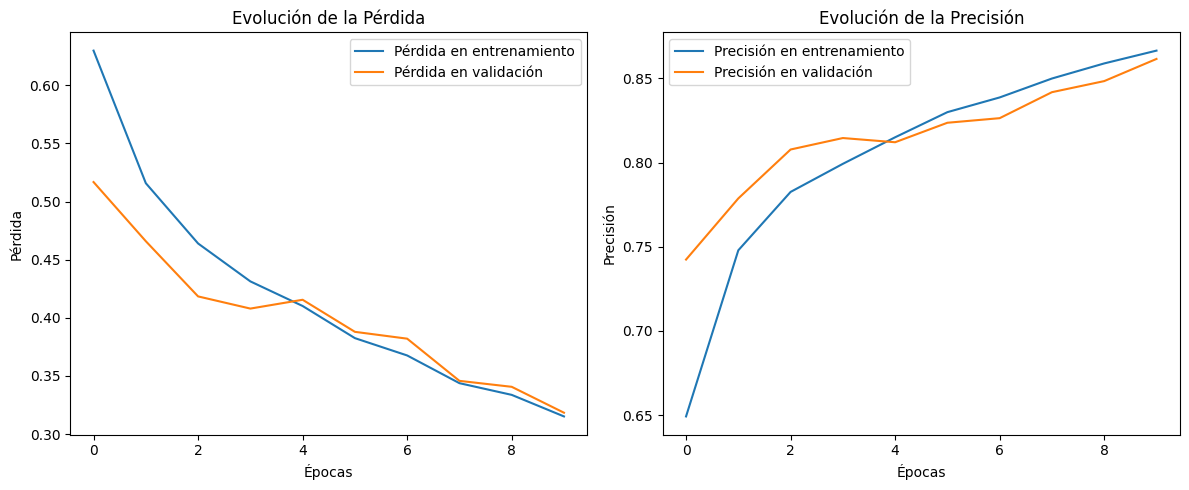

In [6]:

# Extraer métricas del entrenamiento
history_dict = history.history
epochs_range = range(len(history_dict['loss']))

# Crear la figura
plt.figure(figsize=(12, 5))

# Gráfica de la pérdida (Loss)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_dict['loss'], label='Pérdida en entrenamiento')
plt.plot(epochs_range, history_dict['val_loss'], label='Pérdida en validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Evolución de la Pérdida')

# Gráfica de la precisión (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_dict['accuracy'], label='Precisión en entrenamiento')
plt.plot(epochs_range, history_dict['val_accuracy'], label='Precisión en validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Evolución de la Precisión')

# Mostrar la figura
plt.tight_layout()
plt.show()


Evaluar el Modelo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


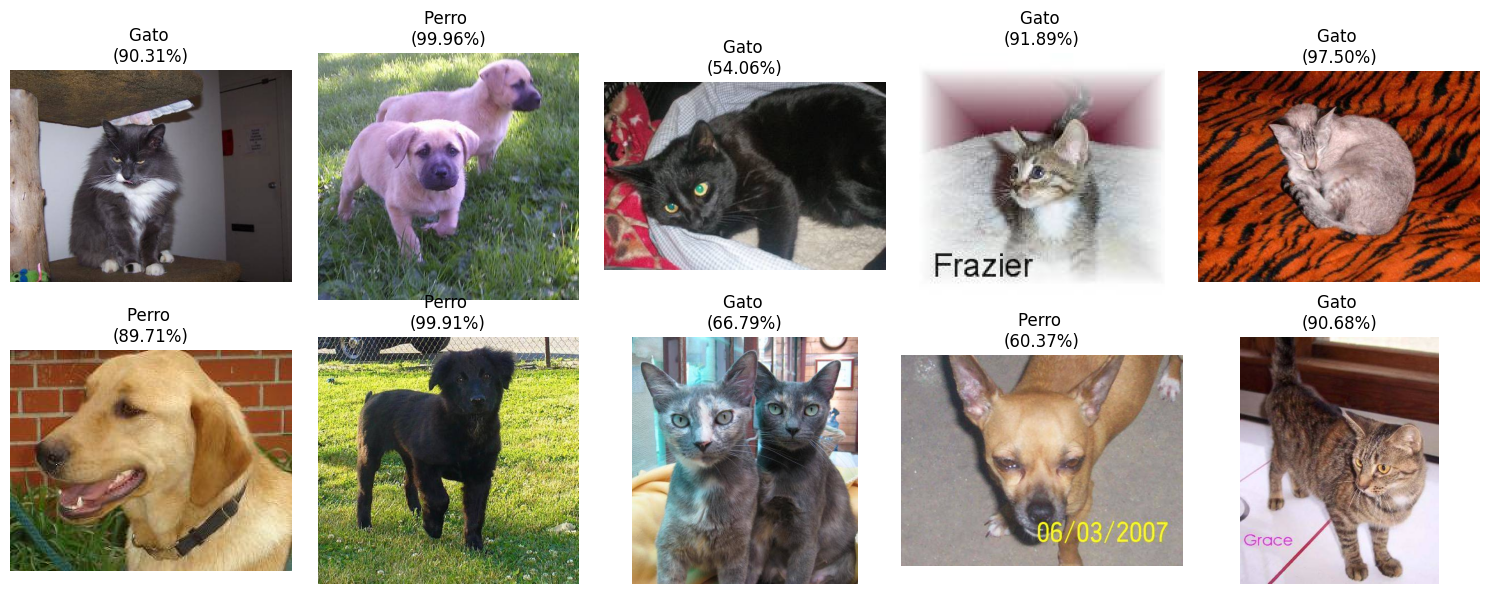

In [13]:
# Función para predecir y mostrar múltiples imágenes
def predict_and_plot_grid(model, img_paths, threshold=0.5):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 filas, 5 columnas
    
    for ax, img_path in zip(axes.flatten(), img_paths):
        img = image.load_img(img_path, target_size=(200, 200))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        prediction = model.predict(img_array)
        pred_label = "Perro " if prediction[0][0] > threshold else "Gato "
        prob = float(prediction[0][0]) if pred_label == "Perro " else 1 - float(prediction[0][0])

        img_bgr = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        ax.imshow(img_rgb)
        ax.set_title(f"{pred_label}\n({prob*100:.2f}%)")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Evaluar 10 imágenes aleatorias de prueba
test_directory = "/workspaces/TensorFlow-Pet-Classifier/data/test"
test_images = [os.path.join(test_directory, fname) for fname in os.listdir(test_directory) if fname.endswith('.jpg') or fname.endswith('.png')]

# Seleccionar 10 imágenes aleatorias
random_images = np.random.choice(test_images, 10, replace=False)
predict_and_plot_grid(model, random_images)
